In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from pinballrt.sources import Star
from pinballrt.grids import UniformCartesianGrid, UniformSphericalGrid
from pinballrt.model import Model
from pinballrt.densities.flared_disk import FlaredDisk
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
star = Star()
star.set_blackbody_spectrum()
disk = FlaredDisk()

In [3]:
model = Model(grid=UniformCartesianGrid, grid_kwargs={"ncells": (24, 24, 24), "dx": 4*u.au})

Warp 1.11.0 initialized:
   CUDA not enabled in this build
   Devices:
     "cpu"      : "arm"
   Kernel cache:
     /Users/bdrechsler/Library/Caches/warp/1.11.0


In [4]:
model.add_component(disk, 'yso.dst')
model.add_star(star)

/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/bdrechsler/miniconda3/envs/pinballrt/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(24, 24, 24)


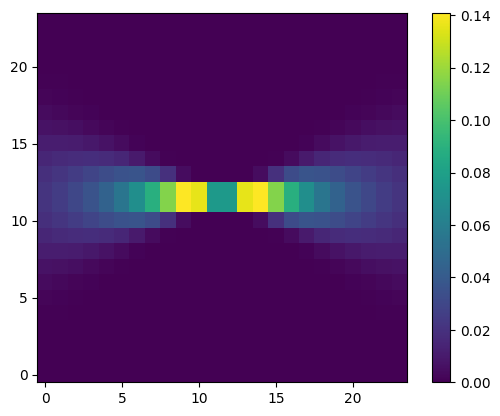

In [7]:
density = model.grid.grid.density.numpy()
print(density.shape)

plt.imshow(np.transpose(density[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [8]:
# model.thermal_mc(nphotons=1000000, device="cuda")
model.thermal_mc(nphotons=1000000)

Iteration 0
Module pinballrt.sources 30a1eec load on device 'cpu' took 2.61 ms  (cached)
Module pinballrt.grids e1b3361 load on device 'cpu' took 2.02 ms  (cached)
Module pinballrt.utils 3047b6a load on device 'cpu' took 0.78 ms  (cached)


100%|████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 356211.12it/s]
/Users/bdrechsler/Code/pinball-rt/pinballrt/grids.py:379: RuntimeWarning: invalid value encountered in divide
  temperature = ((total_energy*u.L_sun).cgs.value / (4*const.sigma_sb.cgs.value*\


0
Iteration 1


100%|████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 354428.20it/s]


1
Iteration 2


100%|████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 347746.12it/s]


2 1.0646288 1.5443097
Iteration 3


100%|████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 348289.95it/s]

3 1.0548921 1.0092301


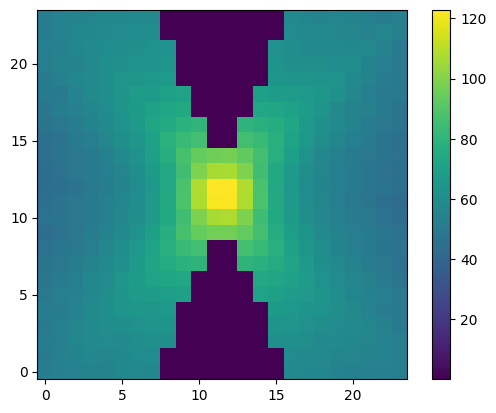

In [9]:
temp = model.grid.grid.temperature.numpy()

plt.imshow(np.transpose(temp[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [10]:
# img = model.make_image(npix=100, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([4, 1000])*u.um, incl=85*u.deg, pa=0*u.deg, device='cuda')

In [11]:
img = model.make_image(npix=50, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([4, 1000])*u.um, incl=80*u.deg, pa=0*u.deg, device='cpu')


100%|██████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 345012.00it/s]


Time: 2.214067220687866


100%|██████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 461176.06it/s]


Time: 2.2374179363250732
2500
Module pinballrt.camera 5759619 load on device 'cpu' took 264.81 ms  (compiled)


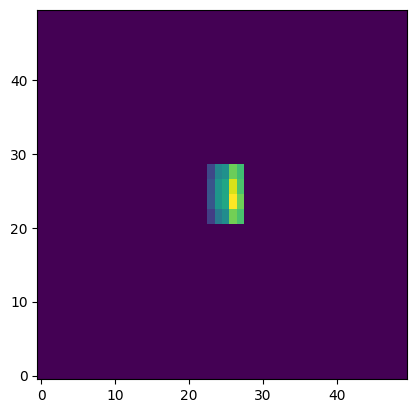

In [12]:
plt.imshow(img.intensity[:,:,0], origin='lower')
plt.show()

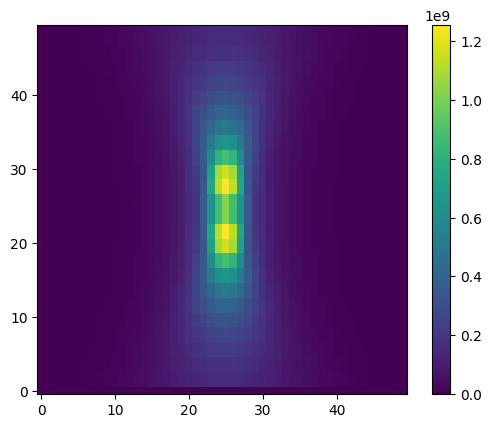

In [13]:
plt.imshow(img.intensity[:,:,1], origin='lower')
plt.colorbar()
plt.show()

In [ ]:
fake_data = img.intensity[